- Check GPU performance if you want to utilize GPU & you can also use it to check GPU memory usage
- !nvidia-smi  

# Libararies 

In [2]:
from transformers import pipeline, set_seed
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

import nltk
from nltk.tokenize import sent_tokenize
from sacrebleu import corpus_bleu

import torch
import numpy as np

import pandas as pd
from datasets import Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import json
import evaluate


# 1. Download and load the necessary libraries and models
nltk.download('punkt', download_dir="data/punkt") #In NLTK, PUNKT is an unsupervised trainable model,

# 2. set up device to compute the model  
device = torch.device("cuda" if torch.cuda.is_available() 
                      else 'mps' if torch.mps.is_available()
                      else "cpu")  
                  
print("Device being used:", device)



# Clear GPU memory to free up memory for the new model
torch.mps.empty_cache()

# torch.mps.set_per_process_memory_fraction(0.0) # to fix memory allocation error when memory allocation is disabled

# #PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to allow training on CPU 

Device being used: mps


[nltk_data] Downloading package punkt to data/punkt...
[nltk_data]   Package punkt is already up-to-date!


## Load the model and tokenizer

In [5]:
# 3. load the model and tokenizer

model_name = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_name) 
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## load the dataset & prepare the training & test sets

In [6]:
# 4. load the dataset

## if you want to load the dataset from disk that not from huggingface hub
# dataset_samsum = load_from_disk('samsum_dataset')
# split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

train_json= 'data/samsum/train.json'
validation_json = 'data/samsum/val.json'
test_json = 'data/samsum/test.json'

# define the function to preprocess the data
def convert_to_df(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df = df.reindex(columns=['id', 'dialogue', 'summary'])
    return df

train_df = convert_to_df(train_json).set_index('id')
validation_df =convert_to_df(validation_json).set_index('id')
test_df = convert_to_df(test_json).set_index('id')


print(f"Split lengths: {train_df.shape, validation_df.shape, test_df.shape}")
print(f"Features: {train_df.columns.tolist()}")

# train data
train_df.head()

Split lengths: ((14732, 2), (818, 2), (819, 2))
Features: ['dialogue', 'summary']


,dialogue,summary
id,,
13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


## examples of dialogues and summaries in the dataset

In [7]:
# test data
print(f"dialogue: {test_df['dialogue'].iloc[0]}")
print("...")
print(f"summary: {test_df['summary'].iloc[0]}")

dialogue: Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
...
summary: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


# Tokenize sentences

In [8]:
# 5. Preprocess the data for tokenization purposes

def convert_ds_to_features(batch_ds):
    input_encodings = tokenizer(batch_ds['dialogue'] , max_length = 1024, truncation = True , padding='max_length')
    target_encodings = tokenizer(batch_ds['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }


# Create the dataset train samples
samsum_train_ds = Dataset.from_pandas(train_df)
samsum_train_ds_pt = samsum_train_ds.map(convert_ds_to_features, batched = True)


samsum_val_ds = Dataset.from_pandas(validation_df)
samsum_val_ds_pt = samsum_val_ds.map(convert_ds_to_features, batched = True)

samsum_test_ds = Dataset.from_pandas(test_df)
samsum_test_ds_pt = samsum_test_ds.map(convert_ds_to_features, batched = True)

samsum_train_ds_pt

Map: 100%|██████████| 819/819 [00:00<00:00, 5191.17 examples/s]


Dataset({
    features: ['dialogue', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14732
})

# 6. Training loop

In [9]:

# Set up the data collator for the model
seq2seq_dataCollector = DataCollatorForSeq2Seq(tokenizer, model=model)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='data/pegasus-samsum-results', 
    num_train_epochs=0.02, 
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01, 
    logging_steps=10, 
    push_to_hub=False,
    eval_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16)

# Initialize the trainer
trainer = Trainer(model=model,
                  args=training_args,
                  processing_class=tokenizer,
                  data_collator=seq2seq_dataCollector,
                  train_dataset=samsum_train_ds_pt, 
                  eval_dataset=samsum_val_ds_pt)



In [10]:
torch.mps.set_per_process_memory_fraction(0.0)  # set the memory footprint for the training process memory computation

In [ ]:
# 6.  start training the model

trainer.train() 

 53%|█████▎    | 10/19 [23:11<30:54, 206.02s/it]

{'loss': 3.2778, 'grad_norm': 456.2216796875, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


 84%|████████▍ | 16/19 [43:53<11:10, 223.62s/it]

## 7. Evaluate the model

In [19]:
#7. evaluate the model

# start evaluation
trainer.evaluate()

# load rouge metric
rouge_metric = evaluate.load('rouge')
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

def genarate_batch_sized_chunks(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i + batch_size]


def evaluate_model_pegasus(model, tokenizer, test_dataset,metric, batch_size=2,device=device ,
                                 column_text='dialogue',
                                column_summary='summary'):

    
    article_batches = list(genarate_batch_sized_chunks(test_dataset[column_text], batch_size))
    target_batches = list(genarate_batch_sized_chunks(test_dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
     

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt",return_token_type_ids=False)
     
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
                                    

            
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]

        # Remove spaces and punctuation from the summaries
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        

        # Add the generated summaries and references to the metric
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
        
    # Compute the ROUGE scores for the current batch of summaries
    score = metric.compute()
    return score

# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores are a set of metrics that measure the similarity between a generated summary or translation and a reference summary or translation
score = evaluate_model_pegasus(
     test_dataset=samsum_test_ds[0:10], 
     metric=rouge_metric, 
     model=trainer.model, 
     tokenizer=tokenizer,
    batch_size = 1, 
    column_text = 'dialogue', 
    column_summary= 'summary'
)

# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores of our predictions
score

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


{'rouge1': np.float64(0.017656708212699594),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.017613826129566336),
 'rougeLsum': np.float64(0.017552127646895774)}

In [20]:
# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores of our predictions
rouge_dict = dict((rn , score[rn]) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=[f"pegasus-samsum"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus-samsum,0.017657,0.0,0.017614,0.017552


## Saved the model & tokenizer

In [21]:
# save model 
trainer.save_model('../data/pegasus-samsum-model')


In [22]:
## Save tokenizer
tokenizer.save_pretrained("../data/pegasus-samsum-results")

('../data/pegasus-samsum-results/tokenizer_config.json',
 '../data/pegasus-samsum-results/special_tokens_map.json',
 '../data/pegasus-samsum-results/spiece.model',
 '../data/pegasus-samsum-results/added_tokens.json',
 '../data/pegasus-samsum-results/tokenizer.json')

## load model and tokenizer

In [23]:
# load model and tokenizer
trainer = AutoTokenizer.from_pretrained("../data/pegasus-samsum-results")

# Prediction on a new example

In [24]:
samsum_test_ds[0]["dialogue"] , samsum_test_ds[0]["summary"]

("Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",
 "Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.")

In [35]:
gen_kwargs = {"max_length":128, "num_beams": 8, "length_penalty": 0.8}

sample_text = samsum_test_ds[0]["dialogue"]
reference = samsum_test_ds[0]["summary"]

modelPipeline = pipeline("summarization", model="../data/pegasus-samsum-model",tokenizer=tokenizer,device=0)


print("Original Dialogue:")
print(f"Dailogue: {sample_text}")
print(f"Summary: {reference}")

print("...")

print("Model Summary:")
print(modelPipeline(sample_text, **gen_kwargs)[0]["summary_text"].replace(" .", ".\n").replace("<n>", ""))


Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Original Dialogue:
Dailogue: Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
Summary: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
...
Model Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him.



In [41]:

gen_kwargs = {"max_length":91, "num_beams": 8, "length_penalty": 0.8}

custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print("Custom Dialogue:")
print(custom_dialogue)


print("...")

print("Model Summary:")
print(modelPipeline(custom_dialogue, **gen_kwargs)[0]["summary_text"].replace(" .", ".\n").replace("<n>", ""))

Custom Dialogue:
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!

...
Model Summary:
Leandro, Lewis and Thom try to write a book about transformers.
What do you think? Leandro: Great idea, how hard can it be?!Lewis: Awesome, let's do it together!


## Fine-Tuning PEGASUS


Average dialogue length: 133.07
Average summary length: 25.67


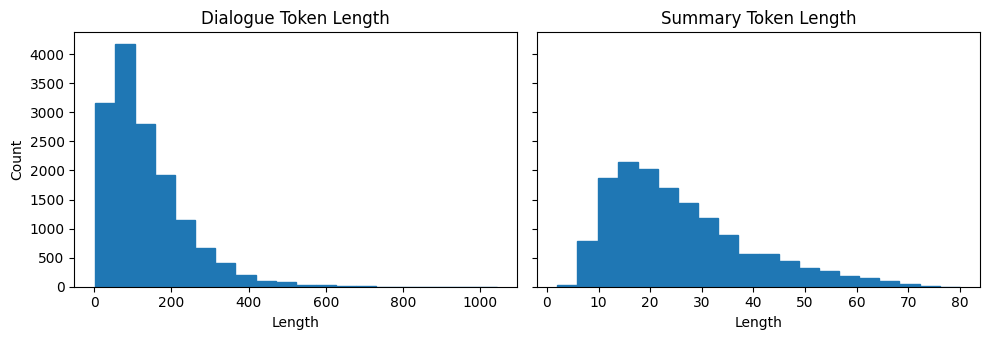

In [44]:


# Calculate the length of the dialogue and summary for each sample
dialogue_length = [len(tokenizer.encode(s)) for s in samsum_train_ds['dialogue']]
summary_length = [len(tokenizer.encode(s)) for s in samsum_train_ds['summary']]

print(f"Average dialogue length: {np.mean(dialogue_length):.2f}")
print(f"Average summary length: {np.mean(summary_length):.2f}")



ig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(dialogue_length, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(summary_length, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


In [45]:
# Select a subset of the training data to fine-tune 
samsum_train_ds
subset_size = 10000
fine_tune_ds = samsum_train_ds_pt.select(range(subset_size))
fine_tune_ds 

Dataset({
    features: ['dialogue', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [48]:
# update the datasets to PyTorch format

columns = ["input_ids", "labels", "attention_mask"]
samsum_train_ds_pt.set_format(type="torch", columns=columns)

columns = ["input_ids", "labels", "attention_mask"]
samsum_test_ds_pt.set_format(type="torch", columns=columns)


In [49]:
#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [64]:
# FIne-tune PEGASUS for text summarization model

# Initialize the PEGASUS model with the tokenizer

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
     
# Set up the training arguments

training_args = TrainingArguments(
    output_dir='../data/pegasus-samsum-finetune',
    num_train_epochs=0.02, 
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10, 
    push_to_hub=False,
    eval_strategy='steps', 
    eval_steps=500, 
    save_steps=1e6,
    gradient_accumulation_steps=16)



# Initialize the PEGASUS model with the tokenizer
trainer = Trainer(model=model, 
                  args=training_args,
                  processing_class=tokenizer, 
                  data_collator=seq2seq_data_collator,
                  train_dataset=samsum_train_ds_pt, 
                  eval_dataset=samsum_val_ds_pt)

# Start training the model
trainer.train()




 53%|█████▎    | 10/19 [23:52<23:55, 159.45s/it]

{'loss': 3.2778, 'grad_norm': 456.2298889160156, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


100%|██████████| 19/19 [48:23<00:00, 165.45s/it]/Users/behar/dev/repo/NLP/text-summarization-pro/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(

100%|██████████| 19/19 [48:38<00:00, 153.58s/it]

{'train_runtime': 2918.0089, 'train_samples_per_second': 0.101, 'train_steps_per_second': 0.007, 'train_loss': 3.1991389425177323, 'epoch': 0.02}


TrainOutput(global_step=19, training_loss=3.1991389425177323, metrics={'train_runtime': 2918.0089, 'train_samples_per_second': 0.101, 'train_steps_per_second': 0.007, 'total_flos': 878397181919232.0, 'train_loss': 3.1991389425177323, 'epoch': 0.020635351615530817})

In [65]:
# Save the fine-tuned model
trainer.save_model("../data/pegasus-samsum-finetune")

# Save the tokenizer
tokenizer.save_pretrained("../data/pegasus-samsum-finetune")

('../data/pegasus-samsum-finetune/tokenizer_config.json',
 '../data/pegasus-samsum-finetune/special_tokens_map.json',
 '../data/pegasus-samsum-finetune/spiece.model',
 '../data/pegasus-samsum-finetune/added_tokens.json',
 '../data/pegasus-samsum-finetune/tokenizer.json')

In [66]:
trainer.evaluate()
# Evaluate the fine-tuned model
score = evaluate_model_pegasus(

    test_dataset=samsum_test_ds[0:10], 
     metric=rouge_metric, 
     model=trainer.model, 
     tokenizer=tokenizer,
    batch_size = 1, 
    column_text = 'dialogue', 
    column_summary= 'summary'
    

   )






100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


In [67]:
score

{'rouge1': np.float64(0.017656708212699594),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.017613826129566336),
 'rougeLsum': np.float64(0.017552127646895774)}

## Predictions

## Test prediction with test dataset

In [71]:

# Load the saved model and tokenizer
trainer = AutoTokenizer.from_pretrained("../data/pegasus-samsum-finetune/checkpoint-19")

# Prediction on a new example
sample_text = samsum_test_ds[0]["dialogue"]
reference = samsum_test_ds[0]["summary"]

modelPipeline = pipeline("summarization", model="../data/pegasus-samsum-finetune",tokenizer=tokenizer,device=0)


print("Original Dialogue:")
print(f"Dailogue: {sample_text}")
print(f"Summary: {reference}")

print("...")

print("Model Summary:")
print(modelPipeline(sample_text, **gen_kwargs)[0]["summary_text"].replace(" .", ".\n").replace("<n>", ""))




Original Dialogue:
Dailogue: Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
Summary: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
...
Model Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him.



## Test with custom dialogue which not part of the training data ,tried to predict the summary

In [74]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.  
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print("Custom Dialogue:")
print(custom_dialogue)


print("...")
print("Model Summary:")
print(modelPipeline(custom_dialogue, **gen_kwargs)[0]["summary_text"].replace(" .", ".\n").replace("<n>", ""))


Custom Dialogue:
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.  
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!

...
Model Summary:
Leandro, Lewis and Thom try to write a book about transformers.
What do you think? Leandro: Great idea, how hard can it be?!Lewis: Awesome, let's do it together!
